In [2]:
import os
import pandas as pd
import numpy as np
import datetime
import json
import matplotlib.pyplot as plt

In [2]:
os.listdir("data/data")

['.DS_Store',
 'kepler_node_platform_joules_total_2024-03-05 21:59:03.543632.csv',
 'kepler_node_package_joules_total_2024-03-05 21:59:01.724486.csv',
 'kepler_container_joules_total_2024-03-05 21:57:50.040954.csv',
 'kepler_node_core_joules_total_2024-03-05 21:56:21.085138.csv',
 'kepler_node_other_joules_total_2024-03-05 21:59:05.038255.csv',
 'kepler_node_dram_joules_total_2024-03-05 21:58:59.655768.csv',
 'node_cpu_seconds_total_2024-03-05 21:56:33.199533.csv',
 'container_cpu_usage_seconds_total_2024-03-05 21:56:53.487299.csv']

In [3]:
data_folder = "data/data/"
cpu_util_file = "node_cpu_seconds_total_2024-03-05 21:56:33.199533.csv"
node_package_power_file = "kepler_node_package_joules_total_2024-03-05 21:59:01.724486.csv"
node_dram_power_file = "kepler_node_dram_joules_total_2024-03-05 21:58:59.655768.csv"

In [4]:
cpu_util = pd.read_csv(data_folder+cpu_util_file)
cpu_util = cpu_util[cpu_util['mode']!='idle']
cpu_util_agg = cpu_util.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
cpu_util_agg['timestamp'] = pd.to_datetime(cpu_util_agg['timestamp'])

node_package_power = pd.read_csv(data_folder+node_package_power_file)
node_package_power = node_package_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_package_power['timestamp'] = pd.to_datetime(node_package_power['timestamp'])

node_dram_power = pd.read_csv(data_folder+node_dram_power_file)
node_dram_power = node_dram_power.groupby(['instance', 'timestamp'], as_index=False)['value'].sum()
node_dram_power['timestamp'] = pd.to_datetime(node_dram_power['timestamp'])

In [5]:
node_power_metrics = pd.merge(node_package_power, node_dram_power, on = ["timestamp", "instance"])
node_power_metrics = node_power_metrics.rename(columns={"value_x":"package", "value_y":"dram"})
node_power_metrics['power'] = node_power_metrics['package'] + node_power_metrics['dram']

In [11]:
node_power_metrics

,instance,timestamp,package,dram,power
0,tantawi1,2024-03-05 03:56:20.104000092,145323.875,78669.993,223993.868
1,tantawi1,2024-03-05 03:56:23.104000092,145336.116,78676.466,224012.582
2,tantawi1,2024-03-05 03:56:26.104000092,145347.638,78682.909,224030.547
3,tantawi1,2024-03-05 03:56:29.104000092,145358.509,78689.366,224047.875
4,tantawi1,2024-03-05 03:56:32.104000092,145374.540,78695.852,224070.392
...,...,...,...,...,...
52398,tantawi2,2024-03-06 03:56:07.334000111,4323009.836,1200608.741,5523618.577
52399,tantawi2,2024-03-06 03:56:10.334000111,4323119.361,1200651.838,5523771.199
52400,tantawi2,2024-03-06 03:56:13.334000111,4323224.236,1200689.450,5523913.686
52401,tantawi2,2024-03-06 03:56:16.334000111,4323334.254,1200732.423,5524066.677


In [14]:
import model

Node :  tantawi1


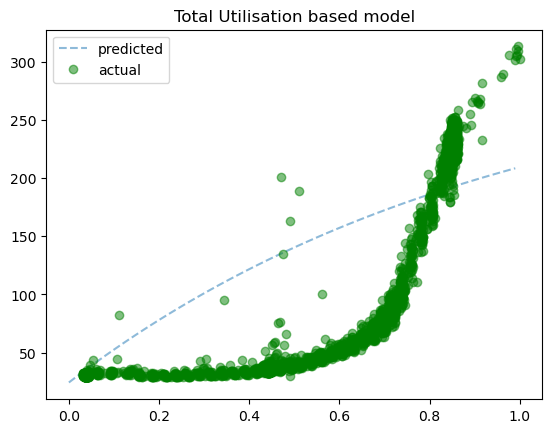

Node :  tantawi2


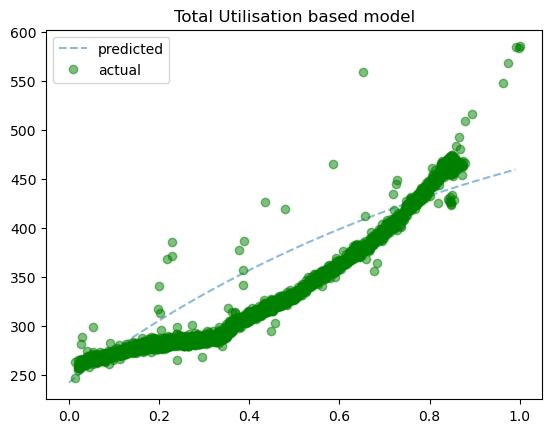

In [16]:
node_power_models = {}
for node in cpu_util_agg['instance'].unique():
    print("Node : ", node)
    cpu = cpu_util_agg[cpu_util_agg['instance']==node]
    power = node_power_metrics[node_power_metrics['instance']==node]
    data = pd.merge_asof(cpu, power, on = 'timestamp')
    data.rename(columns={'value':'util'}, inplace=True)
    data.sort_values('timestamp', inplace=True)
    m = model.UtilisationPowerModel()
    
    node_df = data
    node_df['util'] = node_df['util'].diff()
    node_df['energy'] = node_df['power'].diff()
    node_df.fillna(0, inplace=True)

#     node_df = node_df.iloc[2000: , :]

    node_df = node_df[(node_df[['util']] != 0).all(axis=1)]
    node_df = node_df[(node_df[['energy']] != 0).all(axis=1)]
    max_util = max(node_df['util'])
    node_df['util'] = node_df['util']/max_util

    node_df['power'] = node_df['energy']/3
    node_df['power'].fillna(node_df['power'].mean(), inplace=True)
    node_power_models[node] = m.get_model(node_df[['util', 'power']])

In [17]:
for node in node_power_models:
    print(node,node_power_models[node][2])

tantawi1 (tensor(311.1080, requires_grad=True), tensor(-286.7071, requires_grad=True), tensor(-1.0365, requires_grad=True))
tantawi2 (tensor(583.1961, requires_grad=True), tensor(-340.5179, requires_grad=True), tensor(-1.0237, requires_grad=True))


In [18]:
def get_power(k0, k1, k2, util):
    return k0+k1*np.exp(k2*util)

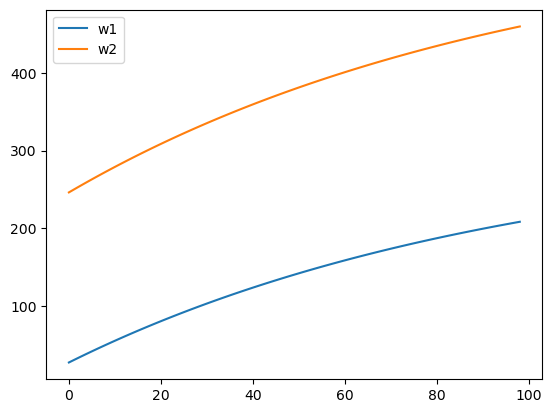

In [20]:
w1 = [get_power(311.1080, -286.7071, -1.0365, i/100) for i in range(1,100)]
w2 = [get_power(583.1961, -340.5179, -1.0237, i/100) for i in range(1,100)]
plt.plot(w1)
plt.plot(w2)
plt.legend(["w1","w2"])

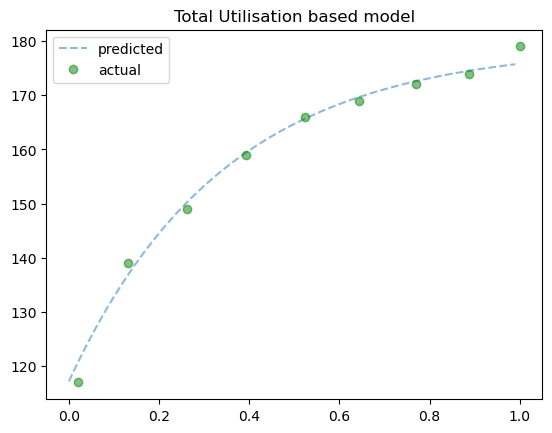

(array([[120.7159 ],
        [136.79349],
        [150.19792],
        [159.3664 ],
        [165.63751],
        [169.65163],
        [172.57628],
        [174.5247 ],
        [175.82265]], dtype=float32),
 [2038.41748046875,
  5.147364616394043,
  3.6360321044921875,
  3.5537467002868652,
  3.541675090789795,
  3.534393310546875,
  3.5275373458862305,
  3.520735502243042,
  3.5139575004577637,
  3.5072314739227295],
 (tensor(179.2110, requires_grad=True),
  tensor(-62.0149, requires_grad=True),
  tensor(-2.9070, requires_grad=True)))

In [21]:
# T1
util = [2,13,26,39,52,64,76.5,88.4,99.5]
power = [117,139,149,159,166,169,172,174,179]
data = pd.DataFrame({'util':util, 'power':power})
data['util'] = data['util']/max(data['util'])
m = model.UtilisationPowerModel()
m.get_model(data)

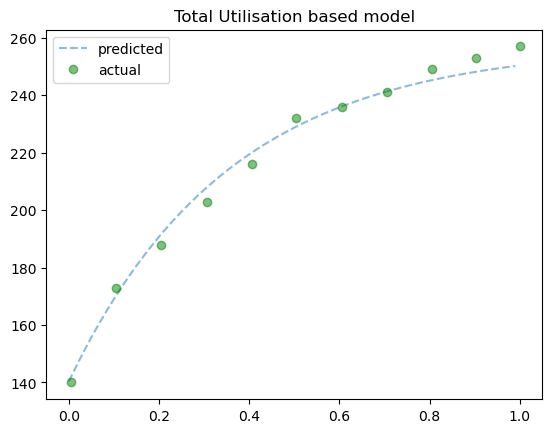

(array([[141.68747],
        [170.15373],
        [191.61765],
        [207.94159],
        [220.0047 ],
        [229.12616],
        [236.08359],
        [241.32959],
        [245.28513],
        [248.2159 ],
        [250.39876]], dtype=float32),
 [7156.525390625,
  14.2857084274292,
  14.243882179260254,
  14.20327091217041,
  14.16290283203125,
  14.122781753540039,
  14.082930564880371,
  14.04330825805664,
  14.003939628601074,
  13.964327812194824],
 (tensor(257.4099, requires_grad=True),
  tensor(-117.0368, requires_grad=True),
  tensor(-2.8150, requires_grad=True)))

In [22]:
# T2
util = [0.4,10.4,20.4,30.5,40.4,50.3,60.3,70.3,80.3,90.1,99.7]
power = [140,173,188,203,216,232,236,241,249,253,257]
data = pd.DataFrame({'util':util, 'power':power})
data['util'] = data['util']/max(data['util'])
m = model.UtilisationPowerModel()
m.get_model(data)